In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Make sure that caffe is on the python path:
caffe_root = '/home/lli-ms/caffe/'
pretrained_model_root = '/home/lli-ms/caffe/'

import sys
caffePython = pretrained_model_root + 'python'
if caffePython not in sys.path:
    sys.path.insert(0, caffePython)
import caffe
import os

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Load mean
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

MODEL_FILE = '../neuralNet/VGG16/vgg16_attr_deploy.prototxt'
PRETRAINED_FILE = caffe_root + 'models/vgg16_attr/snapshots/first_train_iter_2000.caffemodel'
#PRETRAINED_FILE = caffe_root + 'models/VGG16/VGG_ILSVRC_16_layers.caffemodel'
caffe.set_device(1)
caffe.set_mode_gpu()
if not os.path.isfile(PRETRAINED_FILE):
    print("No caffemodel!!!")
elif not os.path.isfile(MODEL_FILE):
    print("No MODEL !!!")
else:
    print "Defining the net!"
    net = caffe.Net(MODEL_FILE,
                PRETRAINED_FILE,
                caffe.TEST)
# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_mean('data', mu)
layersParam = dict()
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)
    layersParam[layer_name]=param
#     maxWeight =   np.max(param[0].data)
#     maxIndex = np.argmax(param[0].data)
#     print maxIndex, maxWeight
conv_blobs = {pr: (net.blobs[pr].data[0]) for pr,param in net.params.iteritems()}
for conv,param in net.params.iteritems():
    print '{} outputs are {} dimensional '.format(conv, conv_blobs[conv].shape)
transformer.set_transpose('data', (2,0,1))
# the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_raw_scale('data', 255) 
# the reference model has channels in BGR order instead of RGB
transformer.set_channel_swap('data', (2,1,0))

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]
Defining the net!
conv1_1	(64, 3, 3, 3) (64,)
conv1_2	(64, 64, 3, 3) (64,)
conv2_1	(128, 64, 3, 3) (128,)
conv2_2	(128, 128, 3, 3) (128,)
conv3_1	(256, 128, 3, 3) (256,)
conv3_2	(256, 256, 3, 3) (256,)
conv3_3	(256, 256, 3, 3) (256,)
conv4_1	(512, 256, 3, 3) (512,)
conv4_2	(512, 512, 3, 3) (512,)
conv4_3	(512, 512, 3, 3) (512,)
conv5_1	(512, 512, 3, 3) (512,)
conv5_2	(512, 512, 3, 3) (512,)
fc_pca	(255, 100352) (255,)
fc_out	(1, 255) (1,)
conv1_1 outputs are (64, 224, 224) dimensional 
conv1_2 outputs are (64, 224, 224) dimensional 
conv2_1 outputs are (128, 112, 112) dimensional 
conv2_2 outputs are (128, 112, 112) dimensional 
conv3_1 outputs are (256, 56, 56) dimensional 
conv3_2 outputs are (256, 56, 56) dimensional 
conv3_3 outputs are (256, 56, 56) dimensional 
conv4_1 outputs are (512, 28, 28) dimensional 
conv4_2 outputs are (512, 28, 28) dimensional 
conv4_3 outputs are (512

In [11]:
from collections import OrderedDict
from collections import Counter
import operator
print '###############fc_out##################'
max_outWeight = np.max(layersParam['fc_out'][0].data)
max_outIndex = np.argmax(layersParam['fc_out'][0].data)
fc_outWeight = layersParam['fc_out'][0].data[0]
print 'MaxIndex:',max_outIndex,' MaxWeight:',max_outWeight
new_outWeight = np.zeros(layersParam['fc_out'][0].data.shape)
new_outWeight[0,max_outIndex] = max_outWeight

print '###############fc_pca##################'
max_pcaWeight = np.max(layersParam['fc_pca'][0].data[10,:])
max_pcaIndex = np.argmax(layersParam['fc_pca'][0].data[10,:])
new_pcaWeight = np.zeros(layersParam['fc_pca'][0].data.shape)
#new_pcaWeight[10,sorted_fc_pca[-10]] = layersParam['fc_pca'][0].data[10,sorted_fc_pca[-10]]


fc_pcaWeight = layersParam['fc_pca'][0].data[10,:]
# print fc_pcaWeight.shape
sorted_fc_pca_index = np.argsort(fc_pcaWeight)[::-1]
sorted_fc_pca  =np.sort(fc_pcaWeight)[::-1]
print 'Min:',sorted_fc_pca[-1], 'Max:',sorted_fc_pca[0]
print '10th Min:',sorted_fc_pca[-10], '10th Max:',sorted_fc_pca[9]
print 'Max 10 Index:',sorted_fc_pca_index[:10]
print 'Min 10 Index:', sorted_fc_pca_index[-10:]

new_pcaWeight = np.zeros(layersParam['fc_pca'][0].data.shape)
new_pcaWeight[10,sorted_fc_pca_index[:10]] = 1*fc_pcaWeight[sorted_fc_pca_index[:10]]
#new_pcaWeight[10,sorted_fc_pca_index[:1000]] = fc_pcaWeight[sorted_fc_pca_index[:1000]]
#print np.max(new_pcaWeight)


print '>>>>>>>>>>>>>>>>>>>>>get the feature maps with max 10 weights'
# sorted_first_index = np.asarray(np.unravel_index(sorted_fc_pca_index[:10], (512,14,14)))
print sorted_fc_pca[0]
sorted_first_index = np.asarray(np.unravel_index(sorted_fc_pca_index[:1000], (512,14,14)))[0,:]
index_occurence_counter = Counter(sorted_first_index)
index_occurence_counter = {x:c for x, c in index_occurence_counter.items() if c >=10}
index_occurence_counter = sorted(index_occurence_counter.items(),\
                                 key=operator.itemgetter(1))[::-1]
print index_occurence_counter[:10]
sorted_first_index = list(OrderedDict.fromkeys(sorted_first_index))
print sorted_first_index[:10]
# print 'MaxIndex:',max_pcaIndex,' MaxWeight:',max_pcaWeight

print '>>>>>>>>>>>>>>>>>>>>>get the feature maps with min 10 weights'
# sorted_first_index = np.asarray(np.unravel_index(sorted_fc_pca_index[:10], (512,14,14)))
print sorted_fc_pca[-1]
sorted_first_index = np.asarray(np.unravel_index(sorted_fc_pca_index[-1000:], (512,14,14)))[0,:]
index_occurence_counter = Counter(sorted_first_index)
index_occurence_counter = {x:c for x, c in index_occurence_counter.items() if c >=10}
index_occurence_counter = sorted(index_occurence_counter.items(),\
                                 key=operator.itemgetter(1))[::-1]
print index_occurence_counter[:10]
sorted_first_index = list(OrderedDict.fromkeys(sorted_first_index))
print sorted_first_index[-10:]
# print 'MaxIndex:',max_pcaIndex,' MaxWeight:',max_pcaWeight
# # sum all the weights for a feature map, 
# # and get the max weighted feature map index;
# fc_pcaWeight = np.reshape(fc_pcaWeight,(512,14,14))
# sum_weight_bl  = np.argsort(np.sum(np.sum(fc_pcaWeight,axis = 2),axis = 1))[::-1][:10]
# print sum_weight_bl
print 'new max Weight:',new_pcaWeight.max()


print '###############conv5_2##################'
new_conv5_2Weight = np.zeros(layersParam['conv5_2'][0].data.shape)
print new_conv5_2Weight.shape
print new_pcaWeight.shape

###############fc_out##################
MaxIndex: 10  MaxWeight: 0.0022502
###############fc_pca##################
Min: -0.00353254 Max: 0.00303773
10th Min: -0.00303835 10th Max: 0.00268023
Max 10 Index: [24395 74195 90687 90686 24380 24381  9793 28073 90673  4769]
Min 10 Index: [15253 54439 54425 15268 15254 12397 64827 77259 15267 77260]
>>>>>>>>>>>>>>>>>>>>>get the feature maps with max 10 weights
0.00303773
[(177, 29), (322, 18), (49, 13), (142, 13), (455, 13), (323, 12), (222, 10), (24, 10), (370, 10), (354, 10)]
[124, 378, 462, 49, 143, 24, 177, 218, 457, 322]
>>>>>>>>>>>>>>>>>>>>>get the feature maps with min 10 weights
-0.00353254
[(20, 27), (121, 22), (221, 15), (394, 14), (179, 13), (77, 13), (63, 12), (150, 12), (339, 12), (206, 11)]
[259, 140, 442, 98, 174, 330, 152, 8, 278, 123]
new max Weight: 0.00303772930056
###############conv5_2##################
(512, 512, 3, 3)
(255, 100352)


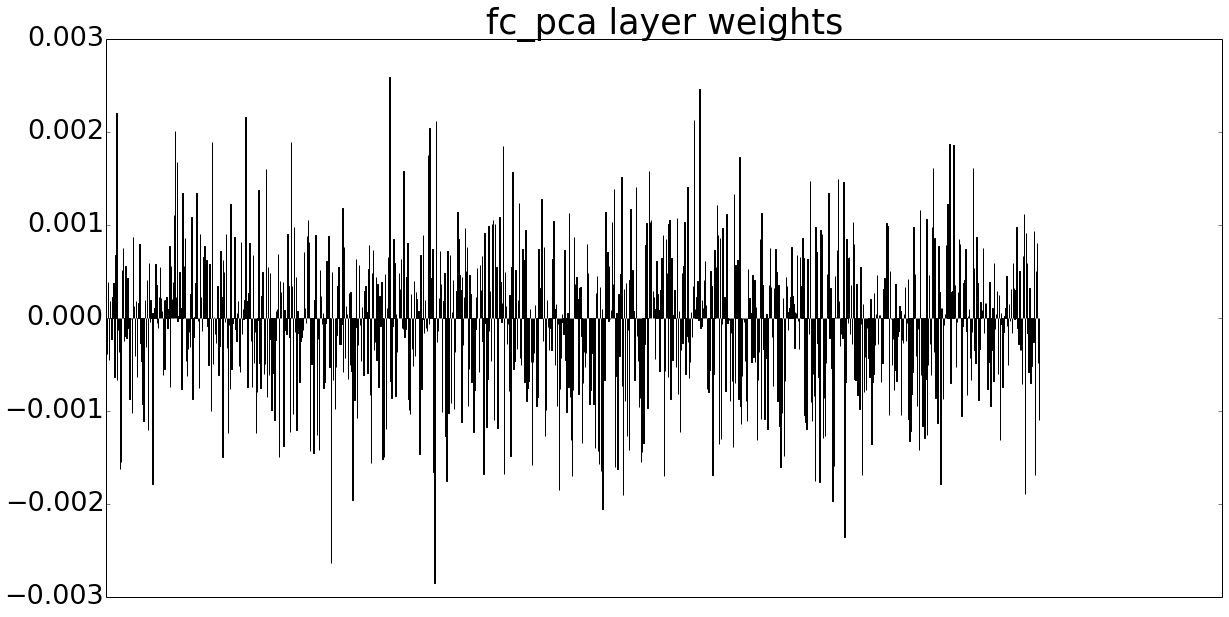

In [346]:
def autolabel(rects,ser):
    # attach some text labels
    max_label = max(ser)
    for rect, var in zip(rects, range(len(ser))):
        height = ser[var]
        if height > 0:
            ypos = 1.02*height
        else:
            ypos = 1.2*height
        if height == max_label:
            ax.text((rect.get_x() + rect.get_width()), ypos,
                    '(%.5f)' % (height), 
                    ha='center', va='bottom',fontsize = lSize-13)

N = fc_pcaWeight[::100].shape[0]
lSize = 35
ind = np.arange(N)  # the x locations for the groups
width = 0.5       # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
rects1 = ax.bar(ind, fc_pcaWeight[::100], width, color='r')

#add some text for labels, title and axes ticks
ax.set_ylabel('',fontsize = lSize)
ax.set_title('fc_pca layer weights',fontsize = lSize)
ax.get_xaxis().set_visible(False)
# ax.set_xticks((ind + width/2)[::10])
# ax.set_xticklabels(range(1,N+1)[::10],fontsize = lSize-8,rotation=70)
ax.tick_params(axis='y', labelsize=lSize-8)

#autolabel(rects1,fc_pcaWeight[::100])
plt.show()
#fig.savefig('../neuralNet/deep-visulization/weights/fc_pcaWeight.png')

In [366]:
params = []
for layer_name, param in net.params.iteritems():
    params.append(layer_name)
pre_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}
print pre_params.keys()

['conv5_1', 'fc_out', 'conv5_2', 'conv4_1', 'conv4_2', 'conv4_3', 'conv3_3', 'conv3_2', 'conv3_1', 'conv1_1', 'fc_pca', 'conv1_2', 'conv2_2', 'conv2_1']


In [367]:
post_params = pre_params
post_params['fc_pca'][0].flat = new_pcaWeight.flat  
post_params['fc_pca'][1][...] = pre_params['fc_pca'][1][...]
post_params['fc_out'][0].flat = new_outWeight.flat  
post_params['fc_out'][1][...] = pre_params['fc_out'][1][...]
# print post_params['fc_out']

In [368]:
net.save('/home/lli-ms/caffe/models/vgg16_attr/vgg16_attr_min_10pca_weight_position.caffemodel')